# Classification with Hidden Markov Models
Running this notebook will:

- load data generated by `01_generate_data.ipynb` from file chosen in setup part
- split data into train and test subsets with chosen ratio
- fit Hidden Markov Models using both AIC and BIC criteria for selection of number of hidden states
- show comparison of number of hidden states in true and fitted models
- run classification on test subset and show results for both AIC and BIC versions in form of confusion matrices
- save results and information about used data filename and split id in pickle file

## Setup

In [17]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import os
import time
from model_class import *
from tqdm import tqdm

RESULTS_DIR = "results_twoPattern"
DATA_PICKLE_FILE = "data_two_pattern/two_pattern_eq_lens.pkl"
RESULTS_NAME_INFIX = "hmm_results_for"
CLS_NAME = "HMM"
FORWARD_SELECTION = True
SEARCH_SPACE = list(range(1,30,2)) # numbers of hidden states to try
SPLIT_ID = 0                    # indices of samples are grouped into train and test 

In [18]:
def fit_with_known_no_hidden_states(samples: list[np.ndarray], no_hidden_states: int, trials: int) -> hmm.GaussianHMM:
    """Fit GaussianHMM when number of hidden states is known.
    EM Algorithm will stuck in local optima, so it is recommended to try to fit model multiple times 
    and select the one with highest score. Number of iterations is set via `trials` argument.
    """
    lengths = [len(sample) for sample in samples]
    X = np.concatenate(samples)
    best_model = None
    best_score = -np.infty
    for t in range(trials):
        remodel = hmm.GaussianHMM(n_components = no_hidden_states).fit(X, lengths)
        if not remodel.monitor_.converged:
            print(f"Model in trial {t} didn't converge.") 
        score = remodel.score(X)
        if score > best_score:
            best_model = remodel
            best_score = score
    return best_model

def AIC(samples: list[np.ndarray], model: hmm.BaseHMM) -> float:
    """Akaike Information Criterion implemented for Hidden Markov Model."""
    lengths = [len(sample) for sample in samples]
    X = np.concatenate(samples)
    loglik = model.score(X, lengths)
    k = model.n_components
    return 2*k - 2*loglik

def BIC(samples: list[np.ndarray], model: hmm.BaseHMM) -> float:
    """Bayesian Information Criterion implemented for Hidden Markov Model."""
    lengths = [len(sample) for sample in samples]
    X = np.concatenate(samples)
    loglik = model.score(X, lengths)
    k = model.n_components
    n = sum(lengths) # TODO jak to dziala jak to rozbijam na czesci?
    return k*np.log(n) - 2*loglik

def fit_and_compute_criteria(samples: list[np.ndarray], search_space: list[int], trials: int, forward_selection: bool = FORWARD_SELECTION) -> dict:
    """Return dict containing models and corresponding information criteria values. If `forward_selection` is True, instead of checking all states in the search space,
    number of hidden states is increased up to 10 and then until criterion stops decreasing which may lead to suboptimal choice
    but makes computation significantly less time consuming."""
    models = []
    AICs = [np.inf]
    BICs = [np.inf]
    for nhs in tqdm(search_space, desc = "Trying different numbers of hidden states..."):
        start_ = time.time()
        model_ = fit_with_known_no_hidden_states(samples, nhs, trials) 
        AIC_ = AIC(samples, model_)
        BIC_ = AIC(samples, model_)
        # print(f"Fitting time for {nhs = }: {time.time() - start_:.2f}s")
        if forward_selection and not(AIC_ < AICs[-1] or BIC_ < BICs[-1]) and nhs > 10:
            print(f"Forward selection stopped due to lack of improvement of both AIC and BIC at {nhs = }")
            return {"models": models, "AIC": AICs[1:], "BIC": BICs[1:]}
        models.append(model_)
        AICs.append(AIC_)
        BICs.append(BIC_)
    return {"models": models, "AIC": AICs[1:], "BIC": BICs[1:]}

def fit_best_models(samples: list[np.ndarray], search_space: list[int], trials: int = 5) -> dict:
    """Fit hmm.GaussianHMM models for all number of hidden states in `search_space` and return mapping between criterion name
    and selected model."""
    results = fit_and_compute_criteria(samples, search_space, trials)
    best_model_id_AIC = np.argmin(results["AIC"]) # Information criteria are minimized, not maximized.
    best_model_id_BIC = np.argmin(results["BIC"])
    return {
        "AIC": results["models"][best_model_id_AIC],
        "BIC": results["models"][best_model_id_BIC]
    }

def classify_sample(X: np.ndarray, fitted_models: list[hmm.BaseHMM]) -> int:
    """Return id of fitted model with best log-likelihood given (one) sample X."""
    scores = [model.score(X) for model in fitted_models]
    return np.argmax(scores)

## Load data and prepare train and test subsets

In [19]:
with open(DATA_PICKLE_FILE, "rb") as f:
    data = pickle.load(f)

data.keys()

dict_keys(['generating_model', 'data_filename', 'time_index', 'models_lst', 'labels_df', 'all_X_samples', 'indices_splits_lst', 'metadata', 'description'])

In [20]:
try: 
    print(data["models_lst"][0])
except Exception as e:
    pass

In [21]:
print(data["metadata"])

{'N_TRAIN_SAMPLES_PER_MODEL': 1000, 'N_TEST_SAMPLES_PER_MODEL': 4000, 'MAX_SAMPLE_LEN': 128, 'MIN_SAMPLE_LEN': 128}


In [22]:
indices_splits_lst = data["indices_splits_lst"]
all_X_samples = data["all_X_samples"]
labels_df = data["labels_df"]
current_split = indices_splits_lst[SPLIT_ID]
train_samples_ids = current_split["train_samples_ids"]
test_samples_ids = current_split["test_samples_ids"]

In [23]:
all_X_samples[0].shape

(128, 1)

## Fit the models: use both AIC and BIC

In [24]:
fitted_models_AIC = []
fitted_models_BIC = []
start = time.time()
for label, sub_df in labels_df.loc[train_samples_ids].groupby("true_label"):
    print(f"Fitting models for label {label} --------------------")
    int_ids = sub_df.index.values.astype('int')
    X = [all_X_samples[id] for id in int_ids]
    fitted_models_dict = fit_best_models(X, SEARCH_SPACE)
    fitted_models_AIC.append(fitted_models_dict["AIC"])
    fitted_models_BIC.append(fitted_models_dict["BIC"])
stop = time.time()
fit_AIC_BIC_time = stop - start

Fitting models for label 0 --------------------


Trying different numbers of hidden states...:  33%|███▎      | 5/15 [00:37<01:15,  7.57s/it]


Forward selection stopped due to lack of improvement of both AIC and BIC at nhs = 11
Fitting models for label 1 --------------------


Trying different numbers of hidden states...:  33%|███▎      | 5/15 [00:33<01:06,  6.64s/it]


Forward selection stopped due to lack of improvement of both AIC and BIC at nhs = 11
Fitting models for label 2 --------------------


Trying different numbers of hidden states...:  33%|███▎      | 5/15 [00:35<01:10,  7.03s/it]


Forward selection stopped due to lack of improvement of both AIC and BIC at nhs = 11
Fitting models for label 3 --------------------


Trying different numbers of hidden states...:  40%|████      | 6/15 [00:49<01:14,  8.25s/it]

Forward selection stopped due to lack of improvement of both AIC and BIC at nhs = 13


### Compare numbers of hidden states fitted and true models (if true models are HMM)

In [25]:
try:
    true_models = data["models_lst"]
except Exception as e:
    pass
print("Number of hidden states in model used to generate samples vs fitted model:")
print("label |true k |fitted k (AIC) |fitted k (BIC)")

k_true_lst = []
k_AIC_lst = []
k_BIC_lst = []
for i in range(len(fitted_models_AIC)):
    try:    
        k_true = true_models[i].n_components
    except Exception:
        k_true = "NA"
    k_fit_AIC = fitted_models_AIC[i].n_components
    k_fit_BIC = fitted_models_BIC[i].n_components
    k_true_lst.append(k_true)
    k_AIC_lst.append(k_fit_AIC)
    k_BIC_lst.append(k_fit_BIC)
    print(f"{i}     |{k_true}      |{k_fit_AIC}              |{k_fit_BIC}")

Number of hidden states in model used to generate samples vs fitted model:
label |true k |fitted k (AIC) |fitted k (BIC)
0     |NA      |9              |9
1     |NA      |9              |9
2     |NA      |9              |9
3     |NA      |11              |11


In [26]:
# save dataframe with fitted no hidden states
hidden_states_df = pd.DataFrame({
    "k_true": k_true_lst,
    "k_fit_AIC": k_AIC_lst,
    "k_fit_BIC": k_BIC_lst
}
)

## Classify test samples

In [27]:
test_df = labels_df.loc[test_samples_ids]
int_ids = test_df.index.values.astype('int')
test_samples = [all_X_samples[id] for id in int_ids]

start = time.time()
predictions_AIC = [classify_sample(X, fitted_models_AIC) for X in test_samples]
predictions_BIC = [classify_sample(X, fitted_models_BIC) for X in test_samples]
stop = time.time()
classify_all_time = stop - start

df_AIC = pd.DataFrame({"pred": predictions_AIC}, index= test_df.index)
df_BIC = pd.DataFrame({"pred": predictions_AIC}, index= test_df.index)

predictions_dfs = {
    "AIC": test_df.join(df_AIC),
    "BIC": test_df.join(df_BIC)
}

predictions_dfs["AIC"].head()

,sample_id,true_label,sample_len,pred
0,0,1,128,2
1,1,2,128,2
2,2,0,128,2
3,3,2,128,2
4,4,1,128,2


In [28]:
fit_predict_time = fit_AIC_BIC_time + classify_all_time
print(f"Time needed to fit models and make predictions: {fit_predict_time:.2f}s")

Time needed to fit models and make predictions: 166.43s


### Show confusion matrices

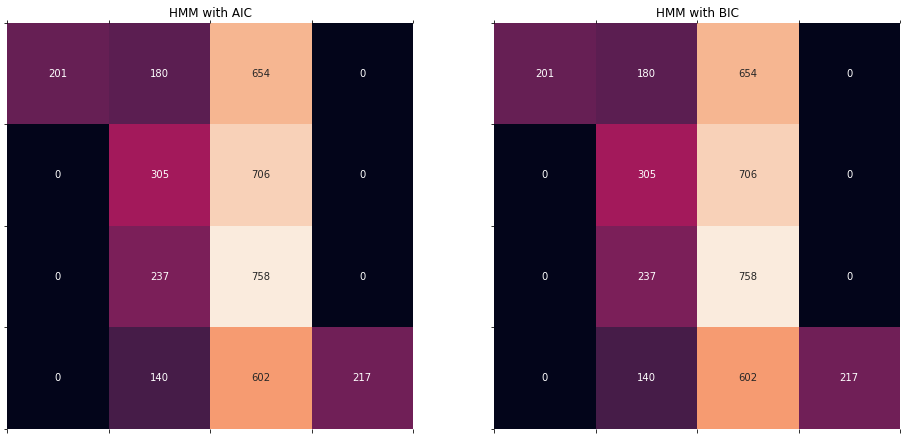

In [29]:
y_true = test_df["true_label"]
y_pred_AIC = predictions_dfs["AIC"]["pred"]
y_pred_BIC = predictions_dfs["BIC"]["pred"]

cm_AIC = confusion_matrix(y_true, y_pred_AIC)
cm_BIC = confusion_matrix(y_true, y_pred_BIC)

plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams['font.size'] = 10
fig, axes = plt.subplots(ncols = 2)
sns.heatmap(cm_AIC, annot=True, fmt='g', ax=axes[0], cbar = False)
axes[0].matshow(cm_AIC)
axes[0].set_title("HMM with AIC")
sns.heatmap(cm_BIC, annot=True, fmt='g', ax=axes[1], cbar = False)
axes[1].matshow(cm_BIC)
axes[1].set_title("HMM with BIC")
plt.show()

In [30]:
accuracies = dict()
for variant, df in predictions_dfs.items():
    acc = utils.accuracy(y_true, df["pred"])
    accuracies[variant] = acc
    print(f"{variant} accuracy: {acc:.4f}")

AIC accuracy: 0.3703
BIC accuracy: 0.3703


## Save classification results

In [31]:
time_index = data["time_index"]
summary = {
    "data_filename": DATA_PICKLE_FILE,
    "hidden_states_df": hidden_states_df,
    "classificator": CLS_NAME,
    "time_index": time_index,
    "split_id": SPLIT_ID,
    "predictions_dfs": predictions_dfs,
    "accuracies": accuracies,
    "total_time": fit_predict_time
}

for key, val in summary.items():
    print(f"{key}: {val}")

data_filename: data_two_pattern/two_pattern_eq_lens.pkl
hidden_states_df:   k_true  k_fit_AIC  k_fit_BIC
0     NA          9          9
1     NA          9          9
2     NA          9          9
3     NA         11         11
classificator: HMM
time_index: 1661531413
split_id: 0
predictions_dfs: {'AIC':       sample_id  true_label  sample_len  pred
0             0           1         128     2
1             1           2         128     2
2             2           0         128     2
3             3           2         128     2
4             4           1         128     2
...         ...         ...         ...   ...
3995       3995           1         128     2
3996       3996           1         128     2
3997       3997           1         128     1
3998       3998           1         128     2
3999       3999           0         128     2

[4000 rows x 4 columns], 'BIC':       sample_id  true_label  sample_len  pred
0             0           1         128     2
1             1

In [32]:
gen_type = data["generating_model"]
split_id_str = str(SPLIT_ID)
if len(split_id_str) == 1:
    split_id_str = "0" + split_id_str

output_path = f"{RESULTS_DIR}/{RESULTS_NAME_INFIX}_{gen_type}_{time_index}_{split_id_str}.pkl"
if os.path.exists(output_path):
    inp = input(f"Classification results {output_path} already exists. Do you want to overwrite it? (y = yes)")
    if inp in ["y", "Y"]:
        with open(output_path, 'wb') as f:
                pickle.dump(summary, f)
                print(f"Updated classification results saved to {output_path}.")
    else:
        print("Canceled.")
else:
    with open(output_path, 'wb') as f:
        pickle.dump(summary, f)
        print(f"Classification results saved to {output_path}.")

Classification results saved to results_twoPattern/hmm_results_for_SIM_TwoPat_1661531413_00.pkl.
